# %%
# Customer Segmentation Exploratory Analysis
# Overview:
# This notebook explores customer segmentation using RFM analysis, K-Means, and DBSCAN clustering 
# on the Online Retail dataset (online_retail.xlsx). It includes time-based analysis and optimal cluster determination.

# Steps:
# 1. Load and preprocess data from online_retail.xlsx
# 2. Perform RFM feature engineering
# 3. Apply K-Means with Elbow method
# 4. Try DBSCAN for outlier detection
# 5. Analyze time-based trends
# 6. Visualize results with scatter plots and boxplots

In [1]:
# %%
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os

In [2]:
# %%
# Load dataset
df = pd.read_excel('../data/online_retail.xlsx')

In [3]:
# %%
# Data Cleaning
df = df.dropna(subset=['CustomerID'])
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [4]:
# %%
# RFM Analysis
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'UnitPrice': lambda x: (x * df.loc[x.index, 'Quantity']).sum()
}).rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'UnitPrice': 'Monetary'})


In [5]:
# %%
# Feature Scaling
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

In [6]:
# %%
# Elbow Method for Optimal K
inertias = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertias.append(kmeans.inertia_)


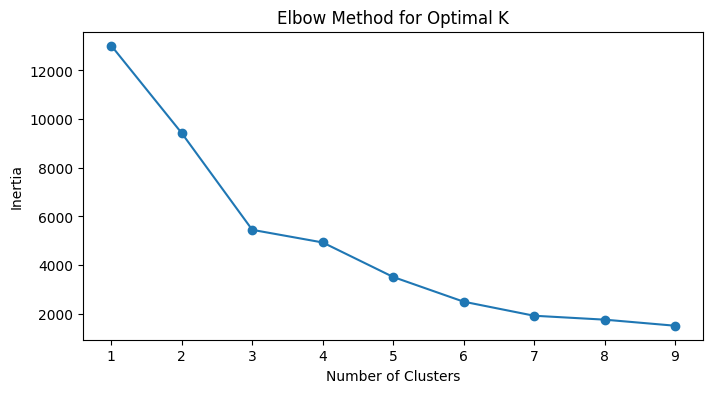

In [7]:
plt.figure(figsize=(8, 4))
plt.plot(range(1, 10), inertias, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [8]:
# %%
# K-Means Clustering (k=4)
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

In [9]:
# %%
# DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
rfm['DBSCAN_Cluster'] = dbscan.fit_predict(rfm_scaled)

In [10]:
# %%
# Segment Profiles (K-Means)
segment_profiles = rfm.groupby('Cluster').agg({
    'Recency': ['mean', 'count'],
    'Frequency': 'mean',
    'Monetary': 'mean'
}).round(2)
print('K-Means Segment Profiles:\n', segment_profiles)

K-Means Segment Profiles:
         Recency       Frequency   Monetary
           mean count      mean       mean
Cluster                                   
0         20.99  2171    135.29    2645.82
1         98.22  1326     37.72     773.88
2          4.69    13   2565.31  126118.31
3        272.41   828     25.14     605.84


In [11]:
# %%
# Assign Segment Names
segment_names = {
    0: 'Champions',
    1: 'Potential Loyalists',
    2: 'At-Risk',
    3: 'New Customers'
}
rfm['Segment'] = rfm['Cluster'].map(segment_names)

In [16]:
# %%
# PCA for Visualization
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)

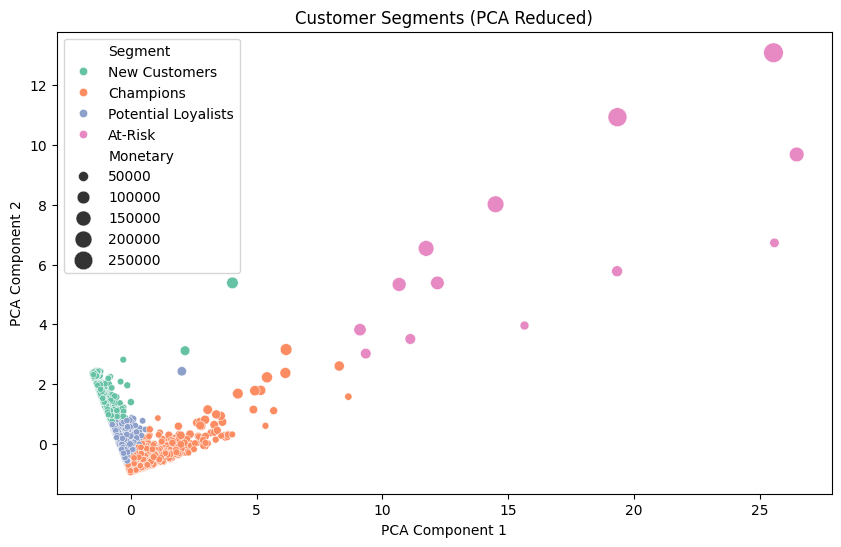

In [17]:
# %%
# Scatter Plot
# Ensure the directory exists
os.makedirs("../assets", exist_ok=True)

# Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=rfm_pca[:, 0], y=rfm_pca[:, 1], hue=rfm['Segment'], palette='Set2', size=rfm['Monetary'], sizes=(20, 200))
plt.title('Customer Segments (PCA Reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.savefig("../assets/cluster_plot.png")  # Save plot
plt.show()

C:\Users\mahes\AppData\Local\Temp\ipykernel_12644\3780669736.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Segment', y=feature, data=rfm, palette='Set2')
C:\Users\mahes\AppData\Local\Temp\ipykernel_12644\3780669736.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Segment', y=feature, data=rfm, palette='Set2')
C:\Users\mahes\AppData\Local\Temp\ipykernel_12644\3780669736.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Segment', y=feature, data=rfm, palette='Set2')


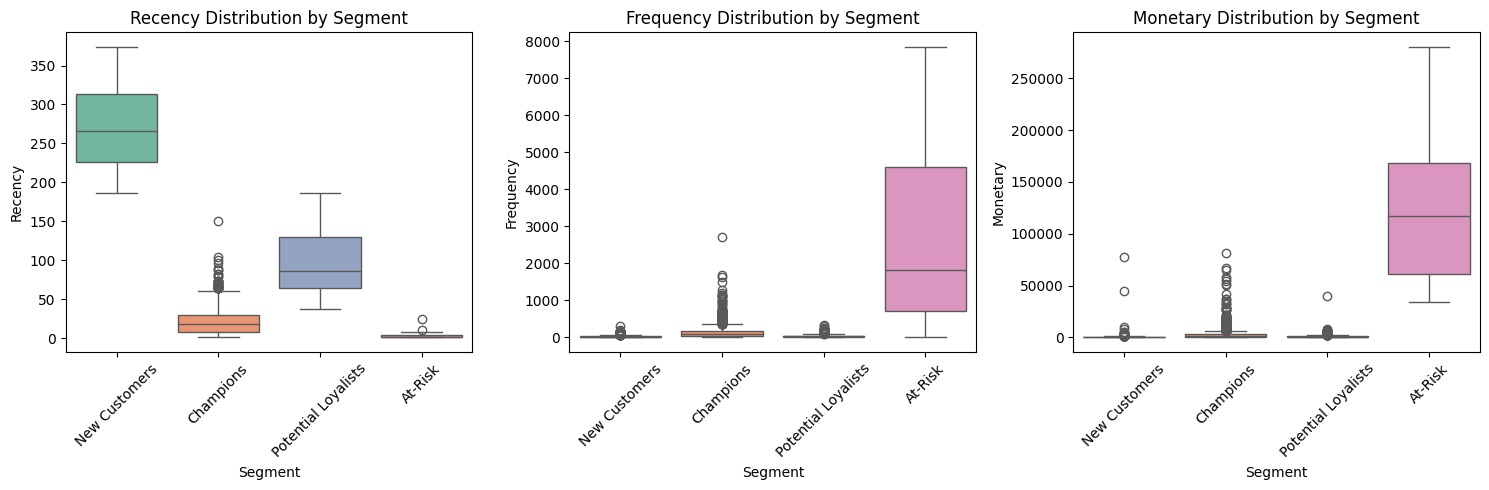

In [18]:
# %%
# Boxplot for RFM Features
plt.figure(figsize=(15, 5))
for i, feature in enumerate(['Recency', 'Frequency', 'Monetary'], 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x='Segment', y=feature, data=rfm, palette='Set2')
    plt.title(f'{feature} Distribution by Segment')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [21]:
# %%
# Time-Based Analysis
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Month'] = df['InvoiceDate'].dt.to_period('M')
monthly_trends = df.groupby('Month')['InvoiceNo'].count().reset_index()
monthly_trends['Month'] = monthly_trends['Month'].astype(str)


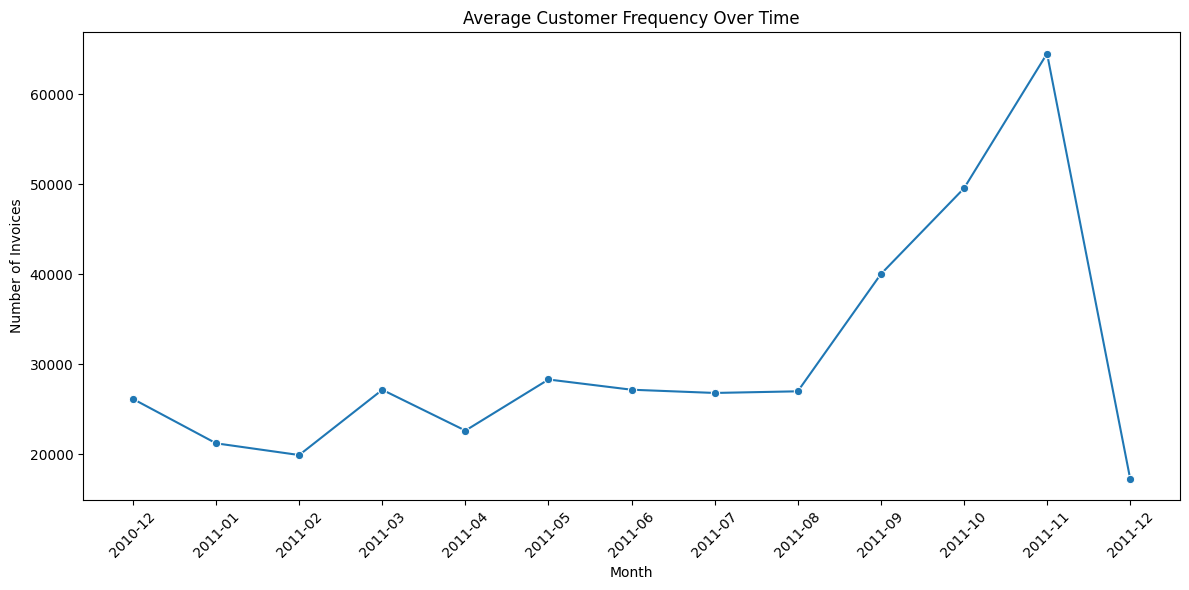

In [22]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='Month', y='InvoiceNo', data=monthly_trends, marker='o')
plt.title('Average Customer Frequency Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Invoices')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
